In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def cm2inch(value):
    return value/2.54

In [4]:
#plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [5]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [6]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks

## HPC Benchmark

0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5             NaN
0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5    8.100720e+10
0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5    8.100720e+10
0    2.531476e+09
1    5.062951e+09
2    1.012590e+10
3    2.025180e+10
4    4.050360e+10
5             NaN
Name: N_conns_sum, dtype: float64

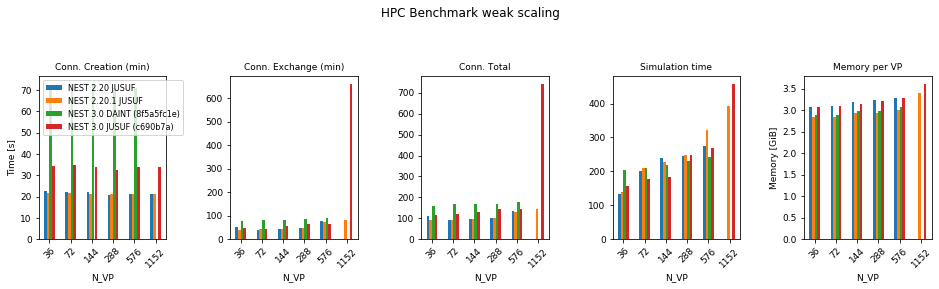

In [6]:
hpc_220 = pd.read_csv('results/jusuf/hpc_benchmark_2_20_jusuf.csv')
hpc_220['Case'] = ['NEST 2.20 JUSUF'] * len(hpc_220)
hpc_2201 = pd.read_csv('results/jusuf/hpc_benchmark_2_20_1_jusuf.csv')
hpc_2201['Case'] = ['NEST 2.20.1 JUSUF'] * len(hpc_2201)

hpc_3_c6 = pd.read_csv('results/jusuf/hpc_benchmark_3_0_c690b7a_jusuf.csv')
hpc_3_c6['Case'] = ['NEST 3.0 JUSUF (c690b7a)'] * len(hpc_3_c6)

hpc_3_8f = pd.read_csv('results/hpc_benchmark_3_0_8f5a5fc1e_daint.csv')
hpc_3_8f['Case'] = ['NEST 3.0 DAINT (8f5a5fc1e)'] * len(hpc_3_8f)

hpc = pd.concat([hpc_220, hpc_2201, hpc_3_c6, hpc_3_8f])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/jusuf/hpc_benchmark_weak_scaling.pdf', legend_loc='upper left',
                     title='HPC Benchmark weak scaling')

hpc['N_conns_sum']

## Multi-Area model

0     18689797
1     56077757
2     80717937
3    162514368
4     21982698
5     43875372
0     27292945
1     49983166
2     87696554
3     11118152
4     21949786
5     43843003
Name: N_spks_sum, dtype: int64

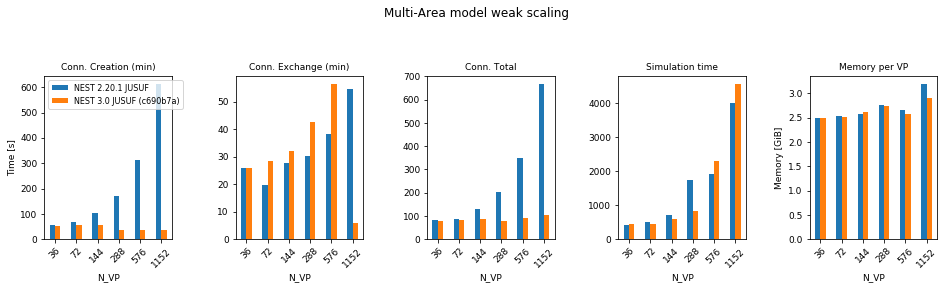

In [12]:
mam_2201 = pd.read_csv('results/jusuf/multi-area_model_2_20_1_jusuf.csv')
mam_2201['Case'] = ['NEST 2.20.1 JUSUF'] * len(mam_2201)

mam_3_c6 = pd.read_csv('results/jusuf/multi-area_model_3_0_c690b7a_jusuf.csv')
mam_3_c6['Case'] = ['NEST 3.0 JUSUF (c690b7a)'] * len(mam_3_c6)

#mam_3_8f = pd.read_csv('results/multi-area_model_3_0_8f5a5fc1e_daint.csv')
#mam_3_8f['Case'] = ['NEST 3.0 DAINT (8f5a5fc1e)'] * len(mam_3_8f)

mam = pd.concat([mam_2201, mam_3_c6])

mam = calculate_T_conn_and_memory(mam)
mam_p = plot_compare(mam, 'figures/jusuf/multi-area_model_weak_scaling.pdf', legend_loc='upper left',
                     title='Multi-Area model weak scaling')

mam['N_spks_sum']

## Multi-Area model, strong scaling

Conn. Creation (min)                    Conn. Exchange (min)  \
Case               NEST 2.20.1 NEST 3.0 (c690b7a)          NEST 2.20.1   
num_tasks                                                                
192                 296.832378          45.384324            38.851040   
288                 293.158535          39.563881            38.339504   
384                        NaN          37.060314                  NaN   
576                        NaN          35.285862                  NaN   

                             Conn. Total                    Memory per task  \
Case      NEST 3.0 (c690b7a) NEST 2.20.1 NEST 3.0 (c690b7a)     NEST 2.20.1   
num_tasks                                                                     
192                47.000000  335.695112          92.403885       10.107443   
288                40.180000  331.516209          79.768034        7.139840   
384                41.400000         NaN          78.483197             NaN   
576                37.669641         NaN          72.974926             NaN   

                             Simulation time                     
Case      NEST 3.0 (c690b7a)     NEST 2.20.1 NEST 3.0 (c690b7a)  
num_tasks                                                        
192                 9.575244     3395.918704        3730.788427  
288                 6.619812     4034.011706        3571.505550  
384                 5.718390             NaN        4357.927361  
576                 4.522181             NaN        4481.362890

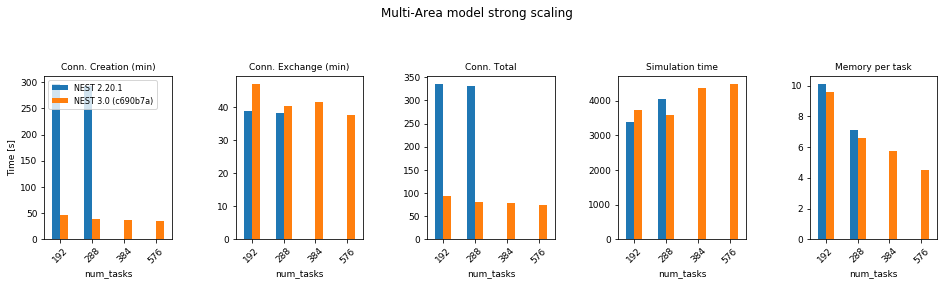

In [9]:
MAM_strong_2201 = pd.read_csv('results/jusuf/multi-area_model_2_20_1_jusuf_strong.csv')
MAM_strong_2201['Case'] = ['NEST 2.20.1'] * len(MAM_strong_2201)

MAM_strong_3_c6 = pd.read_csv('results/jusuf/multi-area_model_3_0_c690b7a_jusuf_strong.csv')
MAM_strong_3_c6['Case'] = ['NEST 3.0 (c690b7a)'] * len(MAM_strong_3_c6)

MAM_strong = pd.concat([MAM_strong_2201, MAM_strong_3_c6])

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
MAM_strong['Memory per task'] = (MAM_strong['VSize_sum']/MAM_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p = plot_compare(MAM_strong, 'figures/jusuf/multi-area_model_strong_scaling_jusuf.pdf', values=values,
                            index='num_tasks', legend_loc='upper left',
                            title='Multi-Area model strong scaling')

MAM_strong_p

## Population model

Conn. Creation (min)                          Conn. Exchange (min)  \
Case    NEST 2.20.1 JUSUF NEST 3.0 JUSUF (c690b7a)    NEST 2.20.1 JUSUF   
N_VP                                                                      
36              34.586005                31.005900            28.871291   
72              46.916655                36.416695            42.912707   
144             71.252512                45.193578            47.267053   
288            121.550554                62.823728            47.831871   
576            219.210398                98.298902            52.124004   
1152           424.698878               166.156728            78.156629   

                                    Conn. Total                           \
Case NEST 3.0 JUSUF (c690b7a) NEST 2.20.1 JUSUF NEST 3.0 JUSUF (c690b7a)   
N_VP                                                                       
36                  43.789083         90.211290               117.747430   
72                  47.119166        181.386278               148.262241   
144                 51.926661        258.406246               188.037398   
288                 59.477669        406.491713               245.472226   
576                 63.619873        723.118357               392.692036   
1152                85.725385       1375.119033               631.449000   

         Memory per VP                           
Case NEST 2.20.1 JUSUF NEST 3.0 JUSUF (c690b7a)  
N_VP                                             
36            3.439235                 3.447903  
72            3.468906                 3.467258  
144           3.612121                 3.655952  
288           3.504879                 3.516222  
576           3.560418                 3.522224  
1152          3.740453                 3.912697

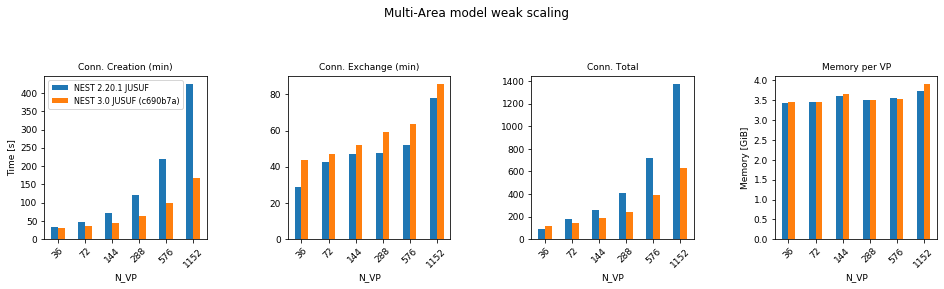

In [16]:
pop_2201 = pd.read_csv('results/jusuf/population_model_2_20_1_jusuf.csv')
pop_2201['Case'] = ['NEST 2.20.1 JUSUF'] * len(pop_2201)

pop_3_c6 = pd.read_csv('results/jusuf/population_model_3_0_c690b7a_jusuf.csv')
pop_3_c6['Case'] = ['NEST 3.0 JUSUF (c690b7a)'] * len(pop_3_c6)

pop = pd.concat([pop_2201, pop_3_c6])

pop = calculate_T_conn_and_memory(pop)
pop_p = plot_compare(pop, 'figures/jusuf/multi-area_model_weak_scaling.pdf', legend_loc='upper left',
                     plot_T_sim=False,
                     title='Multi-Area model weak scaling')

pop_p